# STYLEGAN2-ADA


In [5]:
import generate_nb
import matplotlib.pyplot as plt
import torch
import numpy as np
import dnnlib
import legacy
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import importlib

import projector_nb
importlib.reload(projector_nb)
import numpy as np
import torch
import os
import imageio
from tqdm import tqdm
import matplotlib.pyplot as plt


ModuleNotFoundError: No module named 'sklearn'

### modification of generate

python generate.py --outdir=out --trunc=1 --seeds=85,265,297,849 --network=https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/metfaces.pkl --show


In [2]:
image = generate_nb.generate_images(
    network_pkl='https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/metfaces.pkl',
    seeds=[245],  # single seed for one image
    truncation_psi=1,
    noise_mode='const',
    outdir='out',
    class_idx=None,
    projected_w=None,
    show=True
)

Loading networks from "https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/metfaces.pkl"...
Generating image for seed 245 (0/1) ...


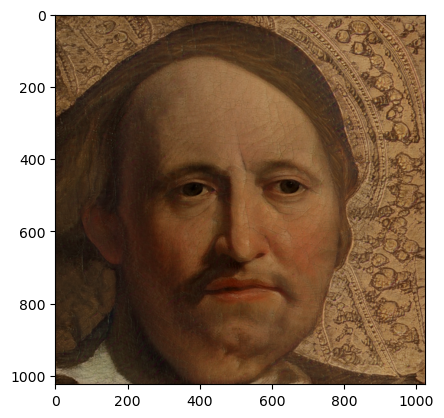

In [6]:
plt.imshow(image)

# Now KPCA

In [8]:
print(torch.cuda.is_available())

device = torch.device('cpu')

print(device)
network = "https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/ffhq.pkl"

False
cpu


In [9]:
with dnnlib.util.open_url(network) as fp:
        G = legacy.load_network_pkl(fp)['G_ema'].requires_grad_(False).to(device)

In [4]:
def generate_samples(G, num_samples):
    z_samples = np.random.RandomState().randn(num_samples, 512).astype(np.float32) 
    
    w_samples = G.mapping(torch.from_numpy(z_samples).to(device), None)  # [N, L, C]
    w_samples = w_samples.cpu().numpy()
    w_samples = w_samples[:,0,:]

    return w_samples

def get_pca(samples):
    
    scaler = StandardScaler()
    w_samples = scaler.fit_transform(samples)  

    pca = PCA(n_components=100)
    pca.fit(w_samples)

    explained_variance = pca.explained_variance_ratio_
    cumulative_explained_variance = np.cumsum(explained_variance)

    # Plot explained variance
    plt.figure(figsize=(10, 6))
    plt.bar(range(1, len(explained_variance) + 1), explained_variance, alpha=0.5, align='center',
        label='Individual Explained Variance')
    plt.step(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, where='mid',
         label='Cumulative Explained Variance')

    plt.xlabel('Principal Component Index')
    plt.ylabel('Explained Variance Ratio')
    plt.title('PCA Explained Variance')
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

    return pca , scaler

In [10]:

w_samples_kpca = generate_samples(G,10000)

from sklearn.decomposition import KernelPCA

KPCA = KernelPCA(n_components=100,  kernel='rbf', coef0=1,fit_inverse_transform=True)
scaler = StandardScaler()
w_samples_kpca = scaler.fit_transform(w_samples_kpca) 

ModuleNotFoundError: No module named 'sklearn'